#Staring Array Modelling

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in Mikhail Konnik's paper at [`arXiv`](http://arxiv.org/pdf/1412.4031.pdf)



## Concept

<font color="red">This is an early draft of the notebook, visit later for a more detailed update.</font>

The current version of the notebook demonstrates Konnik's 'Advanced' model.  For more information and detailed documentation see the [`rystare` documentation](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) or 
[the original Matlab code](https://bitbucket.org/aorta/highlevelsensorsim)

This model experiments with using HDF5 as a structured data store.  The motivation for this use and more information is available [here](https://github.com/NelisW/pyradi/blob/master/pyradi/hdf5-as-data-format.md)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pyradi.ryplot as ryplot
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
# import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
# import pyradi.rymodtran as rymodtran
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
# import xlsxwriter

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at 150 dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

Set up filenames for the run and open the HDF5 file.  

In [2]:
#set up the parameters for this run
outfilename = 'Output'
prefix = 'PA'
pathtoimage = 'W:/MyApps/pyradi/pyradi/data/image-Disk-256-256.hdf5'

#open the file to create data structure and store the results, remove if exists
hdffilename = '{}{}.hdf5'.format(prefix, outfilename)
if os.path.isfile(hdffilename):
    os.remove(hdffilename)

The following code sets up the model data.  

Files remaining open, not closed after use, poses a problem in the notebook context where cells may be executed indivdually.  The limit the occurence of open files we open and close the file in each cell.

In [3]:
strh5 = ryfiles.open_HDF(hdffilename)

#sensor parameters
strh5['rystare/SensorType'] = 'CCD' # must be in capitals
strh5['rystare/FillFactor'] = 1.0 # Pixel Fill Factor for full-frame CCD photo sensors.
strh5['rystare/IntegrationTime'] = 0.01 # Exposure/Integration time, [sec].
strh5['rystare/ExternalQuantumEff'] = 0.8  # external quantum efficiency, fraction not reflected.
strh5['rystare/QuantumYield'] = 1. # number of electrons absorbed per one photon into material bulk
strh5['rystare/FullWellElectrons'] = 2e4 # full well of the pixel (how many electrons can be stored in one pixel), [e]
strh5['rystare/SenseResetVref'] = 3.1 # Reference voltage to reset the sense node. [V] typically 3-10 V.

#sensor noise
strh5['rystare/SenseNodeGain'] = 5e-6 # Sense node gain, A_SN [V/e]

#source follower
strh5['rystare/SourceFollowerGain'] = 1. # Source follower gain, [V/V], lower means amplify the noise.

# Correlated Double Sampling (CDS)
strh5['rystare/CDS-Gain'] = 1. # CDS gain, [V/V], lower means amplify the noise.

# Analogue-to-Digital Converter (ADC)
strh5['rystare/ADC-Num-bits'] = 12. # noise is more apparent on high Bits
strh5['rystare/ADC-Offset'] = 0. # Offset of the ADC, in DN

# Light Noise parameters
strh5['rystare/flag/photonshotnoise'] = True #photon shot noise.
# photo response non-uniformity noise (PRNU), or also called light Fixed Pattern Noise (light FPN)
strh5['rystare/flag/PRNU'] = True
strh5['rystare/noise/PRNU/seed'] = 362436069
strh5['rystare/noise/PRNU/model'] = 'Janesick-Gaussian' 
strh5['rystare/noise/PRNU/parameters'] = [] # see matlab filter or scipy lfilter functions for details
strh5['rystare/noise/PRNU/factor'] = 0.01 # PRNU factor in percent [typically about 1\% for CCD and up to 5% for CMOS];

# Dark Current Noise parameters
strh5['rystare/flag/darkcurrent'] = True
strh5['rystare/OperatingTemperature'] = 300. # operating temperature, [K]
strh5['rystare/DarkFigureMerit'] = 1. # dark current figure of merit, [nA/cm2].  For very poor sensors, add DFM
#  Increasing the DFM more than 10 results to (with the same exposure time of 10^-6):
#  Hence the DFM increases the standard deviation and does not affect the mean value.
strh5['rystare/DarkCurrentElecrons'] = 0.  #to be computed

# dark current shot noise
strh5['rystare/flag/DarkCurrent-DShot'] = True

#dark current Fixed Pattern Noise 
strh5['rystare/flag/DarkCurrentDarkFPN-Pixel'] = True
# Janesick's book: dark current FPN quality factor is typically between 10\% and 40\% for CCD and CMOS sensors
strh5['rystare/noise/darkFPN/DN'] = 0.3 
strh5['rystare/noise/darkFPN/seed'] = 362436128
strh5['rystare/noise/darkFPN/limitnegative'] = True # only used with 'Janesick-Gaussian' 

strh5['rystare/noise/darkFPN/model'] = 'LogNormal' #suitable for long exposures
strh5['rystare/noise/darkFPN/parameters'] = [0., 0.4] #first is lognorm_mu; second is lognorm_sigma.

#dark current Offset Fixed Pattern Noise 
strh5['rystare/flag/darkcurrent_offsetFPN'] = True
strh5['rystare/noise/darkFPN_offset/model'] = 'Janesick-Gaussian'
strh5['rystare/noise/darkFPN_offset/parameters'] = [] # see matlab filter or scipy lfilter functions for details
strh5['rystare/noise/darkFPN_offset/DNcolumn'] = 0.0005 # percentage of (V_REF - V_SN)

# Source Follower VV non-linearity
strh5['rystare/flag/VVnonlinearity'] = False

#ADC
strh5['rystare/flag/ADCnonlinearity'] = 0 
strh5['rystare/ADC-Gain'] = 0.

#source follower noise.
strh5['rystare/flag/sourcefollowernoise'] = True
strh5['rystare/noise/sf/CDS-SampleToSamplingTime'] = 1e-6 #CDS sample-to-sampling time [sec].
strh5['rystare/noise/sf/flickerCornerHz'] = 1e6 #flicker noise corner frequency $f_c$ in [Hz], where power spectrum of white and flicker noise are equal [Hz].
strh5['rystare/noise/sf/dataClockSpeed'] = 20e6 #MHz data rate clocking speed.
strh5['rystare/noise/sf/WhiteNoiseDensity'] = 15e-9 #thermal white noise [\f$V/Hz^{1/2}\f$, typically \f$15 nV/Hz^{1/2}\f$ ]
strh5['rystare/noise/sf/DeltaIModulation'] = 1e-8 #[A] source follower current modulation induced by RTS [CMOS ONLY]
strh5['rystare/noise/sf/FreqSamplingDelta'] = 10000. #sampling spacing for the frequencies (e.g., sample every 10kHz);

#charge to voltage
strh5['rystare/flag/Venonlinearity'] = False

#sense node reset noise.
strh5['rystare/sn/V-FW'] = 0.
strh5['rystare/sn/V-min'] = 0.
strh5['rystare/sn/C-SN'] = 0.
strh5['rystare/flag/SenseNodeResetNoise'] = True
strh5['rystare/noise/sn/ResetKTC-Sigma'] = 0.
strh5['rystare/noise/sn/ResetFactor'] = 0.8 #[0,1]the compensation factor of the Sense Node Reset Noise: 

#For testing and measurements only:
strh5['rystare/flag/darkframe'] = False # True if no signal, only dark

strh5.flush()
strh5.close()

Download the image file from the GitHub directory. Normally you will prepare this file for your specific application.  The format for this file is described [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.create_HDF5_image).

In [4]:
pathtoimage = ryfiles.downloadFileUrl('https://github.com/NelisW/pyradi/raw/master/pyradi/data/image-Disk-256-256.hdf5',  
                              saveFilename='image-Disk-256-256.hdf5')

if pathtoimage is not None:
    imghd5 = ryfiles.open_HDF(pathtoimage)
else:
    imghd5 = None        

The input data has been set up, now execute the model. To test the model performance at the limits, uncomment one of the two `scaleInput` lines.  The first line provides a signal with small SNR whereas the second line provides a signal that saturates the well.

In [5]:
# scaleInput = 0.01 # for low SNR
# scaleInput = 5 # saturates the well to full capacity
scaleInput = 1 

if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    
    #images must be in photon rate irradiance units q/(m2.s)
    strh5['rystare/SignalPhotonRateIrradiance'] = scaleInput * imghd5['image/PhotonRateIrradiance'].value
    strh5['rystare/pixelPitch'] = imghd5['image/pixelPitch'].value
    strh5['rystare/imageName'] = imghd5['image/imageName'].value
    strh5['rystare/imageSizePixels'] = imghd5['image/imageSizePixels'].value

    #calculate the noise and final images
    strh5 = rystare.photosensor(strh5) # here the Photon-to-electron conversion occurred.
    strh5.flush()
    strh5.close()


Print some statistics of the sensor, noise and image

In [6]:
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalPhotonRateIrradiance',np.mean(strh5['rystare/SignalPhotonRateIrradiance'].value), np.var(strh5['rystare/SignalPhotonRateIrradiance'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('signalLight',np.mean(strh5['rystare/signalLight'].value), np.var(strh5['rystare/signalLight'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('signalDark',np.mean(strh5['rystare/signalDark'].value), np.var(strh5['rystare/signalDark'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('source_follower_noise',np.mean(strh5['rystare/noise/sf/source_follower_noise'].value), np.var(strh5['rystare/noise/sf/source_follower_noise'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalPhotons',np.mean(strh5['rystare/SignalPhotons'].value), np.var(strh5['rystare/SignalPhotons'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalElectrons',np.mean(strh5['rystare/SignalElectrons'].value), np.var(strh5['rystare/SignalElectrons'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalVoltage',np.mean(strh5['rystare/SignalVoltage'].value), np.var(strh5['rystare/SignalVoltage'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalDN',np.mean(strh5['rystare/SignalDN'].value), np.var(strh5['rystare/SignalDN'].value)))
    
    strh5.flush()
    strh5.close()


SignalPhotonRateIrradiance: mean=7.17961e+15, var=8.52308e+31
signalLight               : mean=1.43589e+03, var=3.40958e+06
signalDark                : mean=2.31321e+01, var=1.37506e+02
source_follower_noise     : mean=-1.76617e-02, var=3.73296e+01
SignalPhotons             : mean=1.79490e+03, var=5.32699e+06
SignalElectrons           : mean=1.45851e+03, var=3.40971e+06
SignalVoltage             : mean=3.09271e+00, var=8.52428e-05
SignalDN                  : mean=2.98704e+02, var=1.43012e+05


In [7]:
def plotResults(imghd5, hdffilename, arrayname, bins=50):
    if imghd5 is not None and hdffilename is not None:
        #open the sensor data file
        strh5 = ryfiles.open_HDF(hdffilename)
        #get the prescribed array
        arr = strh5['{}'.format(arrayname)].value
        
        his, bin = np.histogram(arr,bins=bins)
        
        if np.min(arr) != np.max(arr):
            arrshift = arr - np.min(arr)
            arrshift = 255 * arrshift/np.max(arrshift)
            p = ryplot.Plotter(1,1,2,figsize=(8, 4))
            p.showImage(1, arr, ptitle=arrayname, cmap=mcm.jet, cbarshow=True);
            p.showImage(2, arrshift, ptitle=arrayname, cmap=mcm.gray, cbarshow=False);
        
        r = ryplot.Plotter(2,1,1,figsize=(7, 2))
        r.plot(1, (bin[1:]+bin[:-1])/2, his, '{}, {} bins'.format(arrayname, bins), 'Magnitude','Counts / bin')

        strh5.flush()
        strh5.close()

The externally created signal in photon rate irradiance [q/(m2.s)]. In this case this is a blurred disk.  Other applications may use any image (in appropriate units).

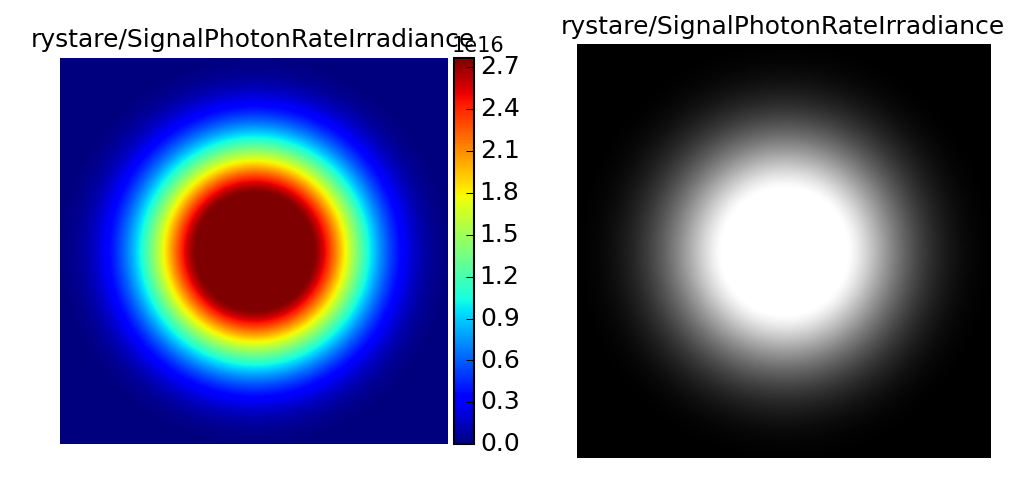

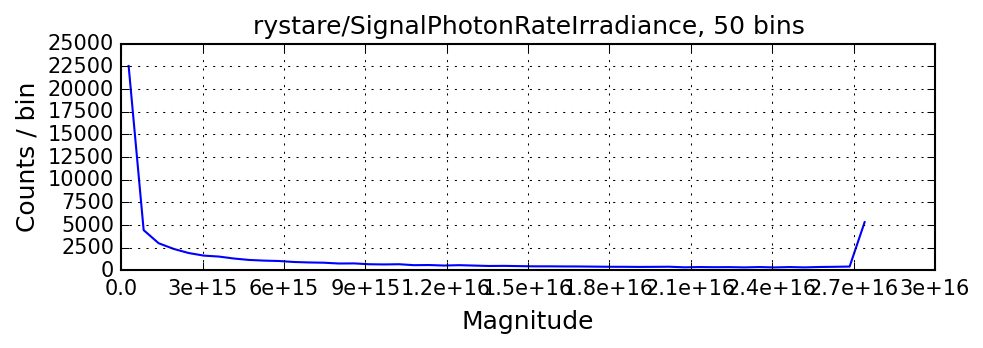

In [8]:
plotResults(imghd5, hdffilename, 'rystare/SignalPhotonRateIrradiance', bins=50) 

The photon rate irradiance multiplied with the detector area yields the photon rate in one detector:

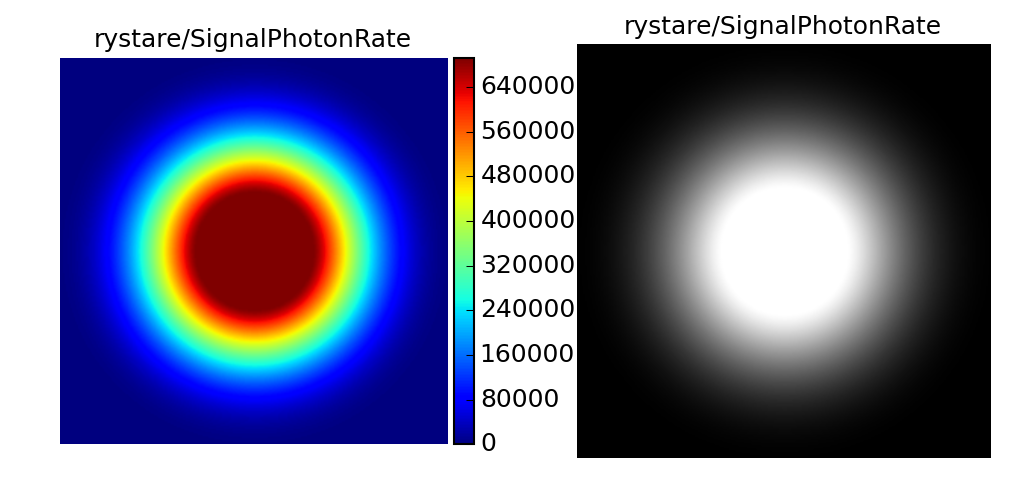

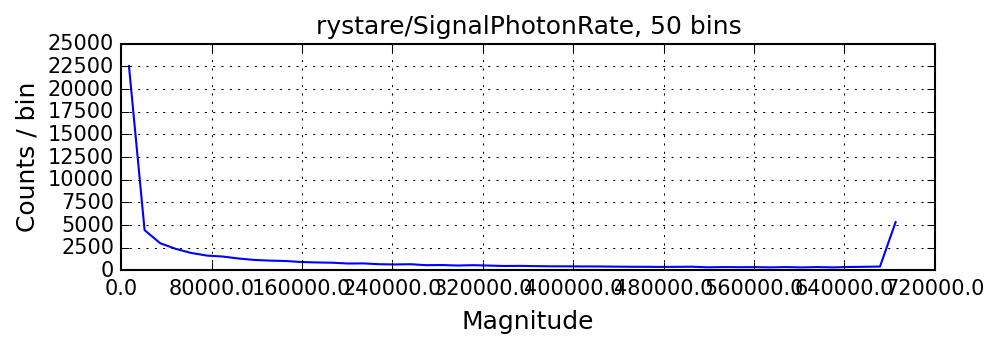

In [9]:
plotResults(imghd5, hdffilename, 'rystare/SignalPhotonRate', bins=50) 

The photon rate multiplied with the integration time yields the maximum number of photons available for accumulation. 

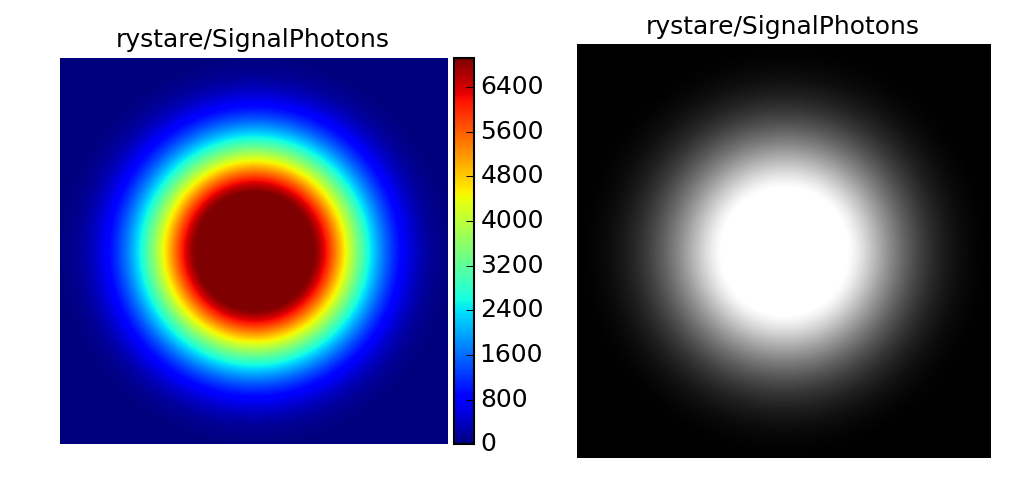

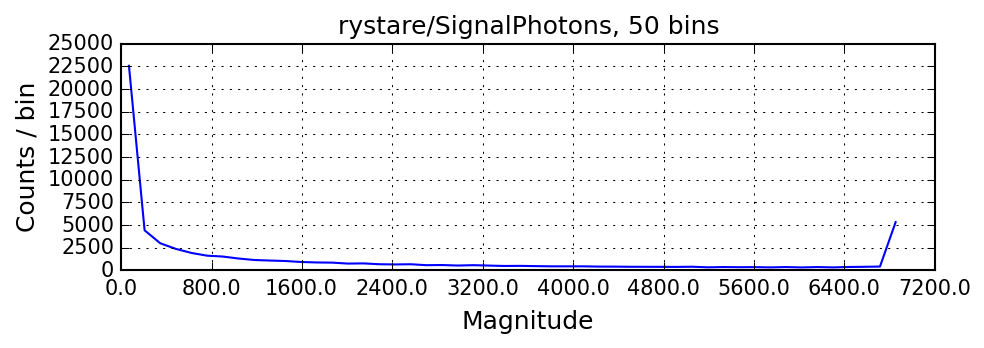

In [10]:
plotResults(imghd5, hdffilename, 'rystare/SignalPhotons', bins=50) 

Detector element quantum efficiency

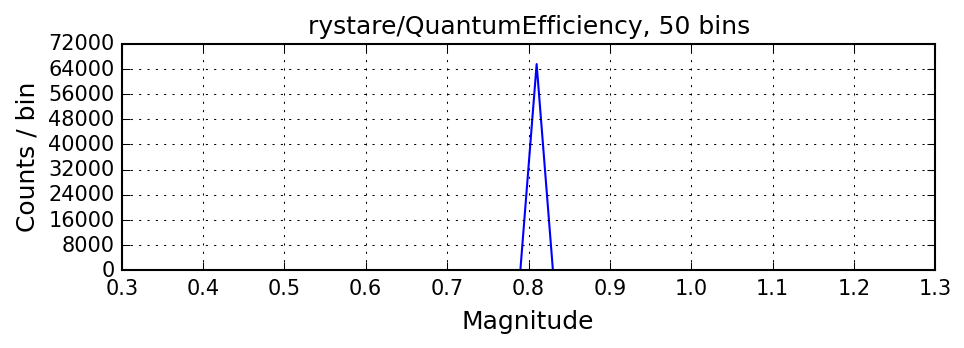

In [11]:
plotResults(imghd5, hdffilename, 'rystare/QuantumEfficiency', bins=50) 

The focal plane's spatial nonuniformity is calculated next, as a Gaussian distribution around unity:

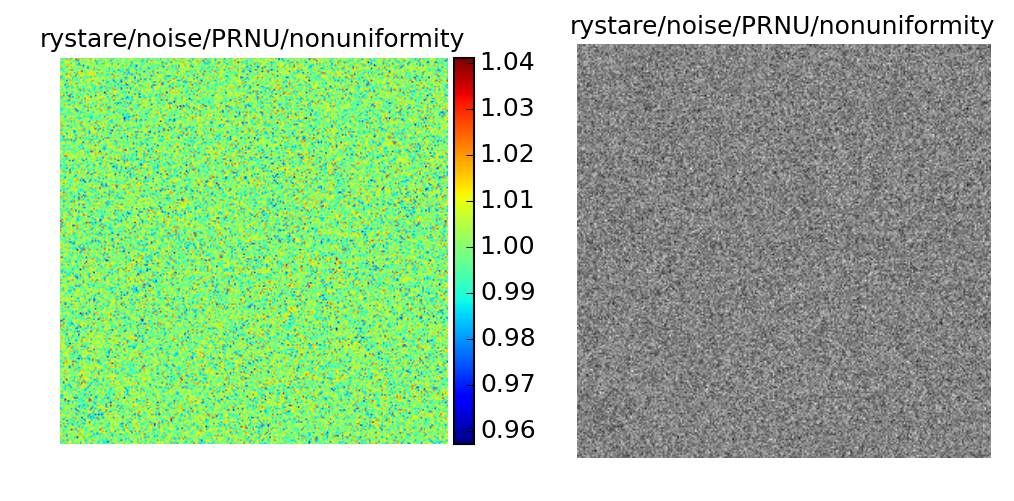

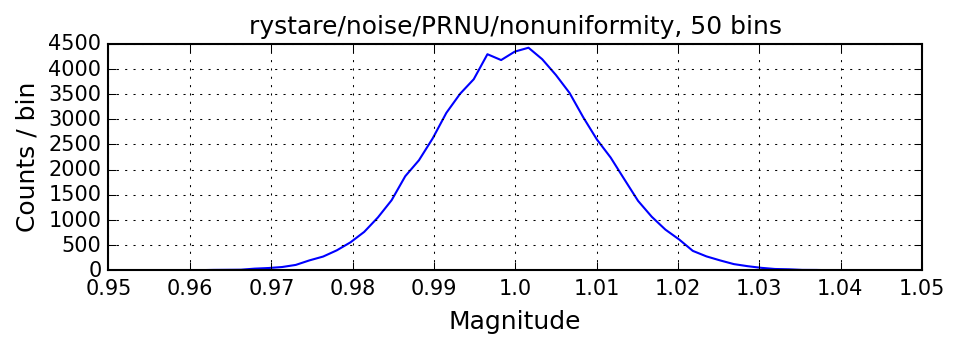

In [12]:
plotResults(imghd5, hdffilename, 'rystare/noise/PRNU/nonuniformity', bins=50) 

The photon count multiplied with the nonuniformity yields the photon count actually recorded in the charge wells:

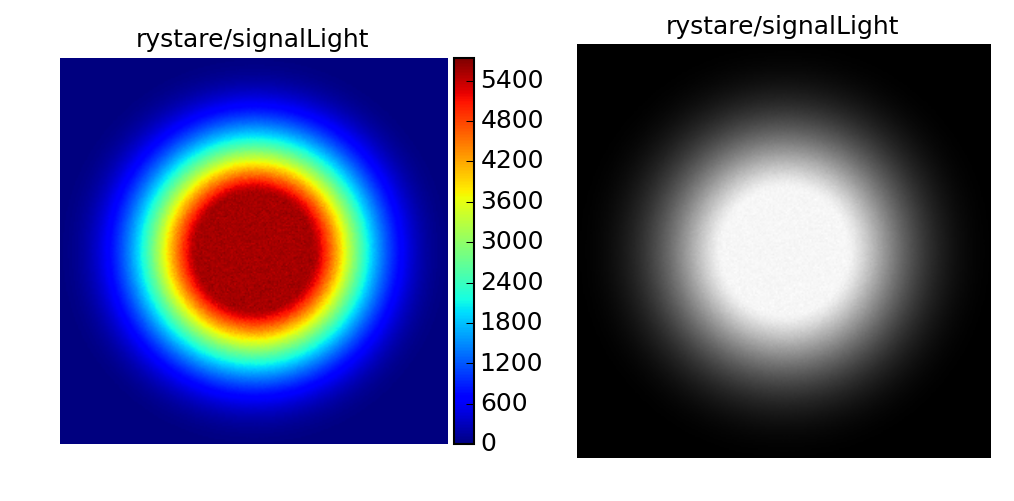

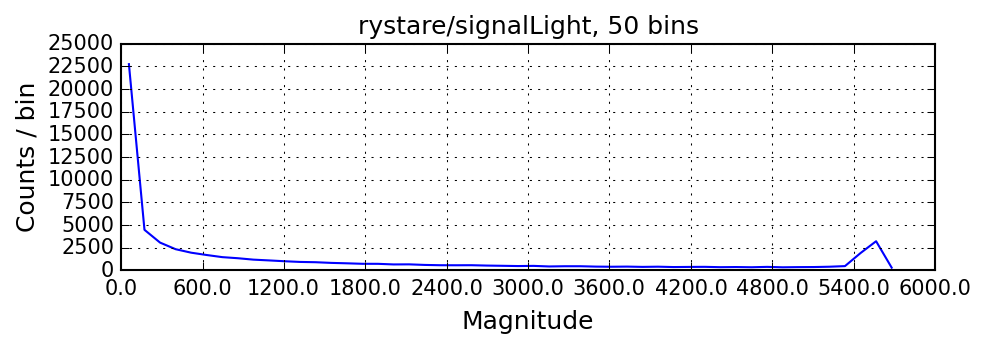

In [13]:
plotResults(imghd5, hdffilename, 'rystare/signalLight', bins=50) 

The focal plane nonuniformity for dark noise generation for the advanced model follows a lognormal distribution.  The relatively few high values are quite evident in these graphs:


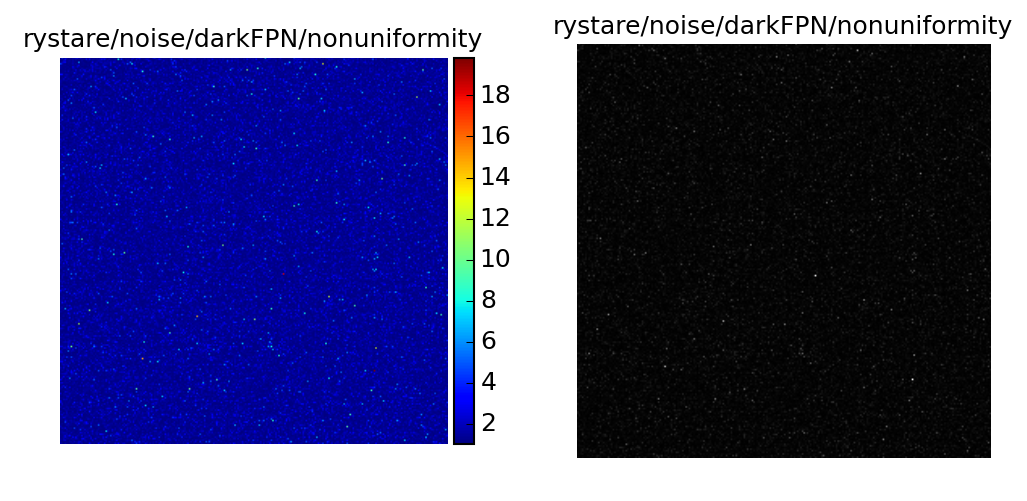

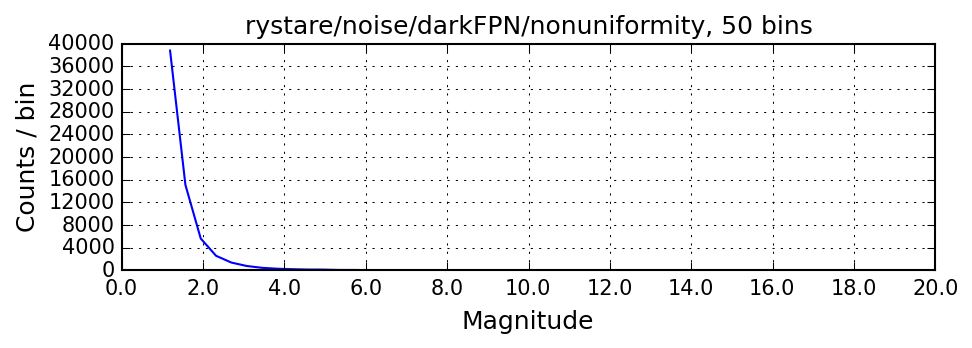

In [14]:
plotResults(imghd5, hdffilename, 'rystare/noise/darkFPN/nonuniformity', bins=50) 


The dark noise signal is given by the dark noise nonuniformity multiplied by the mean dark current:


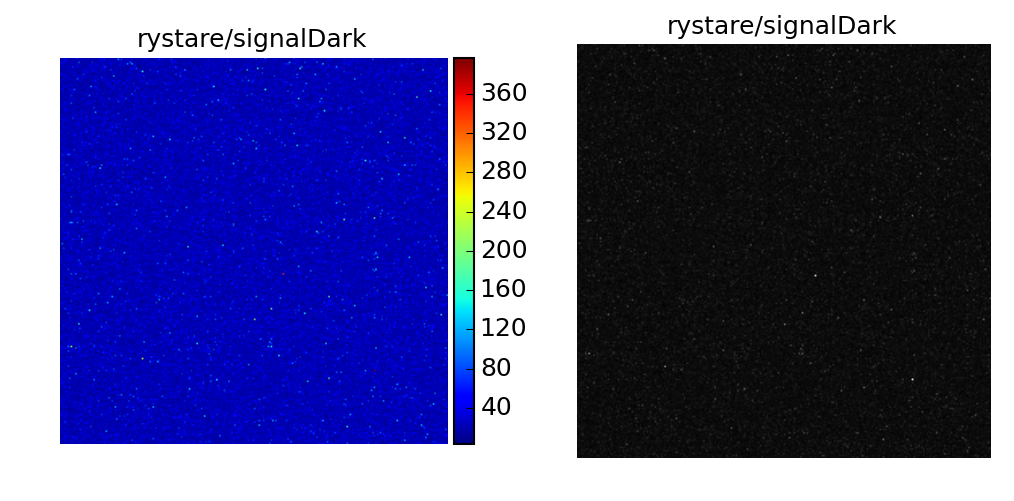

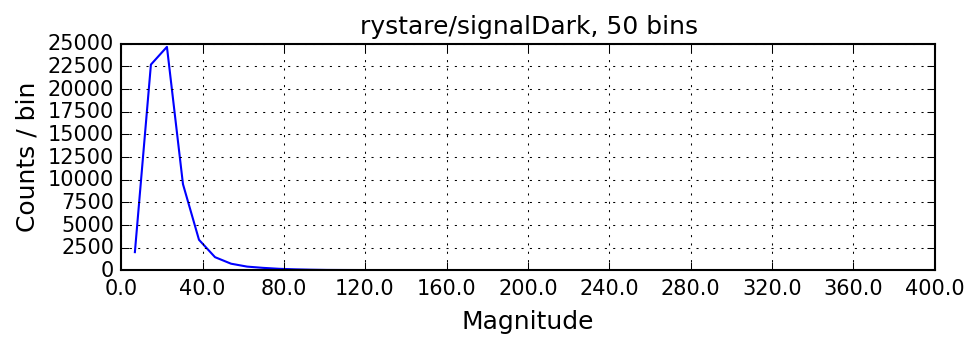

In [15]:
plotResults(imghd5, hdffilename, 'rystare/signalDark', bins=50) 

The reset noise variation over the array:

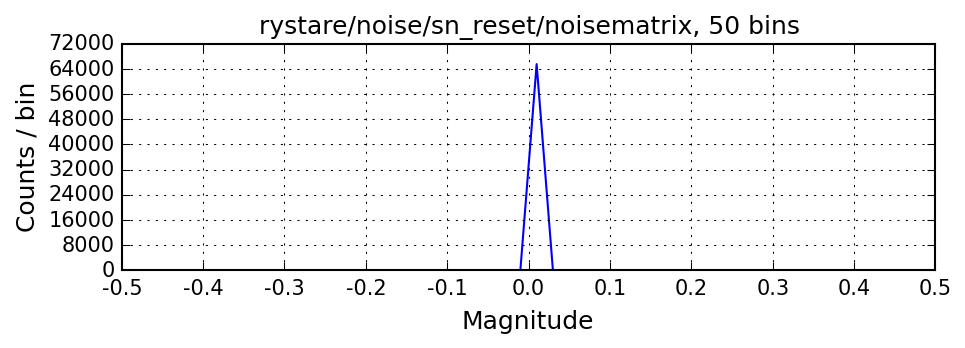

In [16]:
plotResults(imghd5, hdffilename, 'rystare/noise/sn_reset/noisematrix', bins=50) 

The source follower noise in electrons

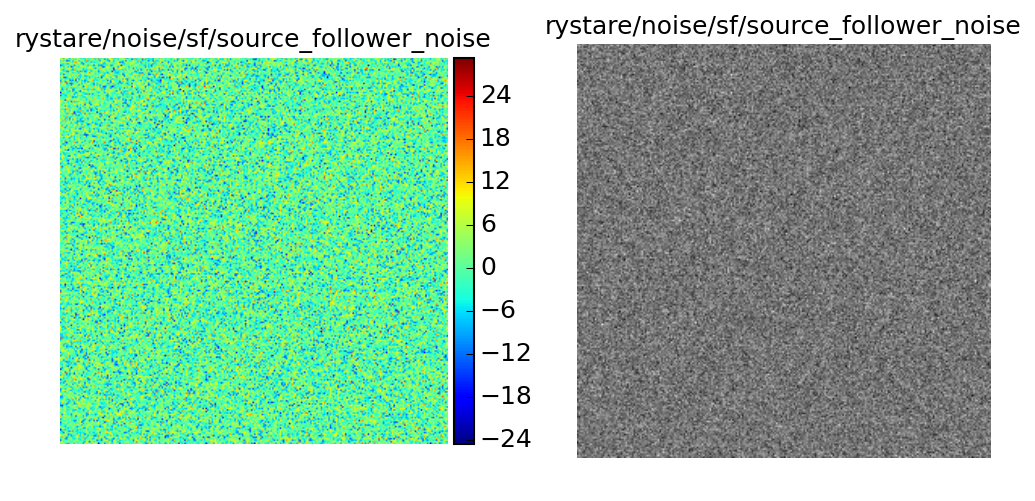

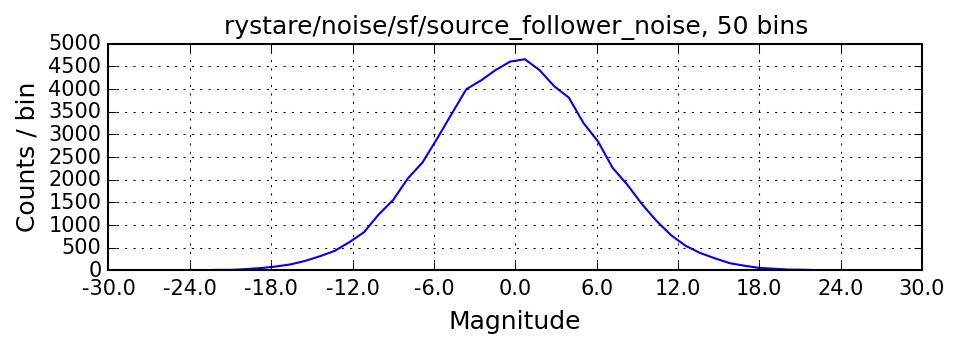

In [17]:
plotResults(imghd5, hdffilename, 'rystare/noise/sf/source_follower_noise', bins=50) 

The signal after all noise sources has been added:

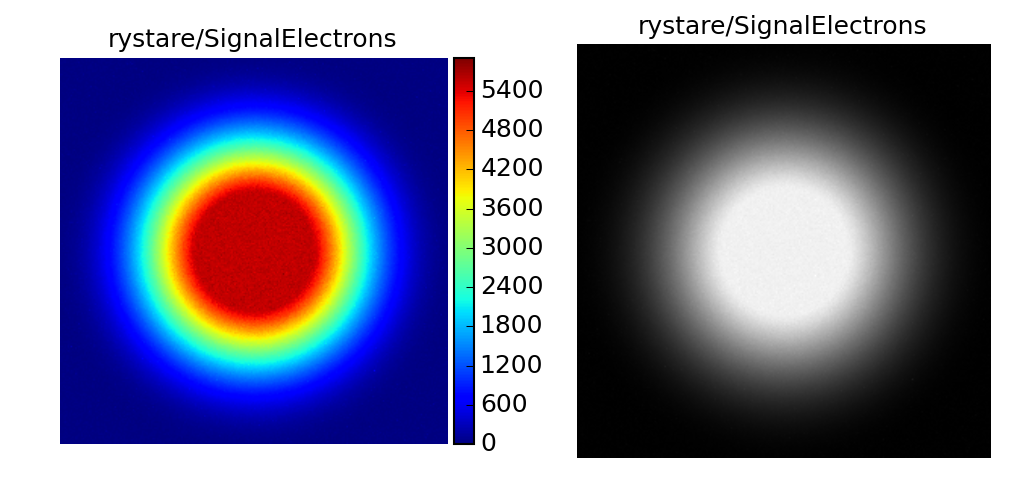

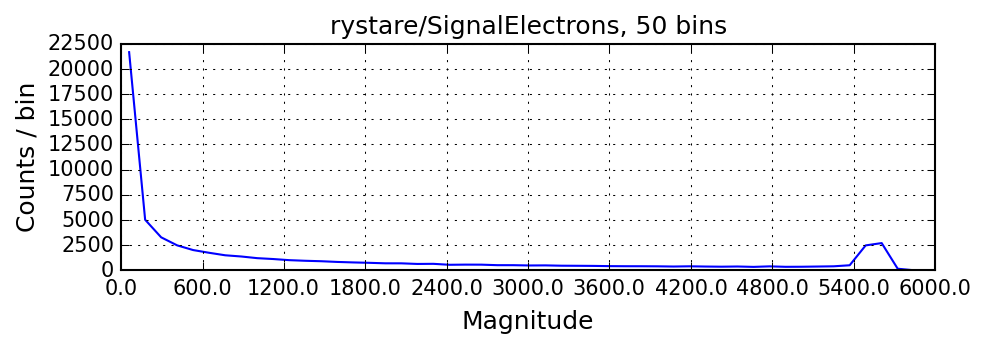

In [18]:
plotResults(imghd5, hdffilename, 'rystare/SignalElectrons', bins=50) 

The (inverted) signal converted to voltage on the FPA output

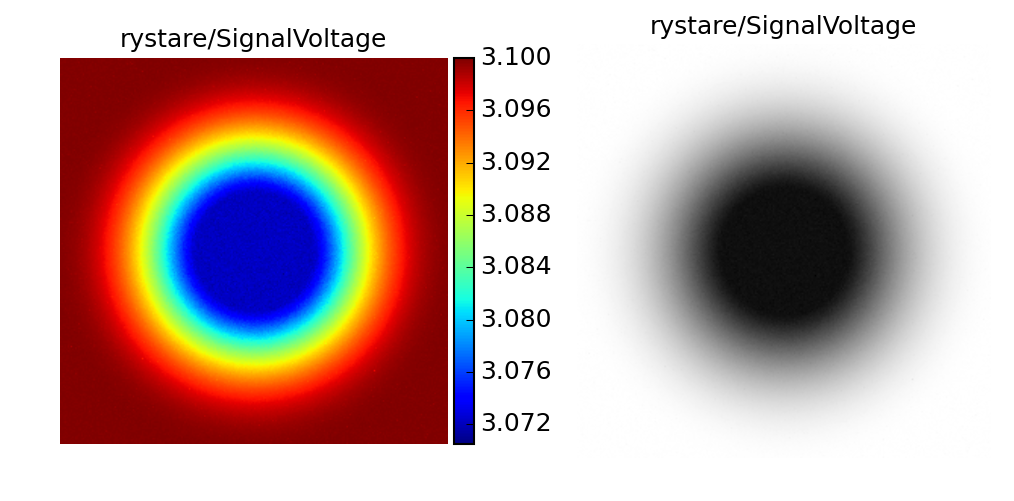

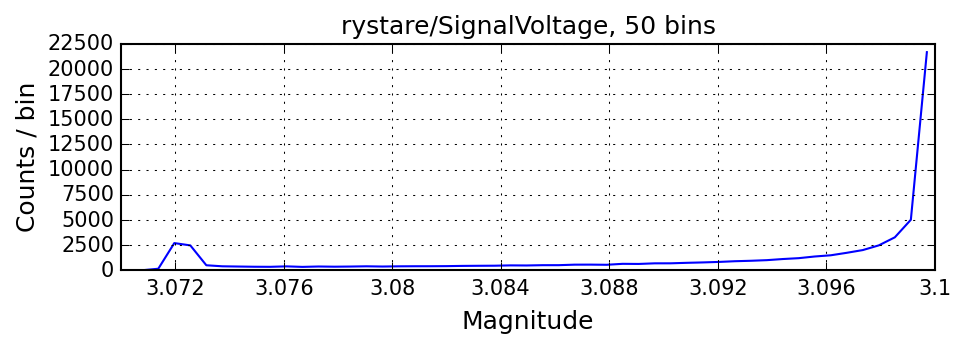

In [19]:
plotResults(imghd5, hdffilename, 'rystare/SignalVoltage', bins=50) 

Signal converted to digital counts

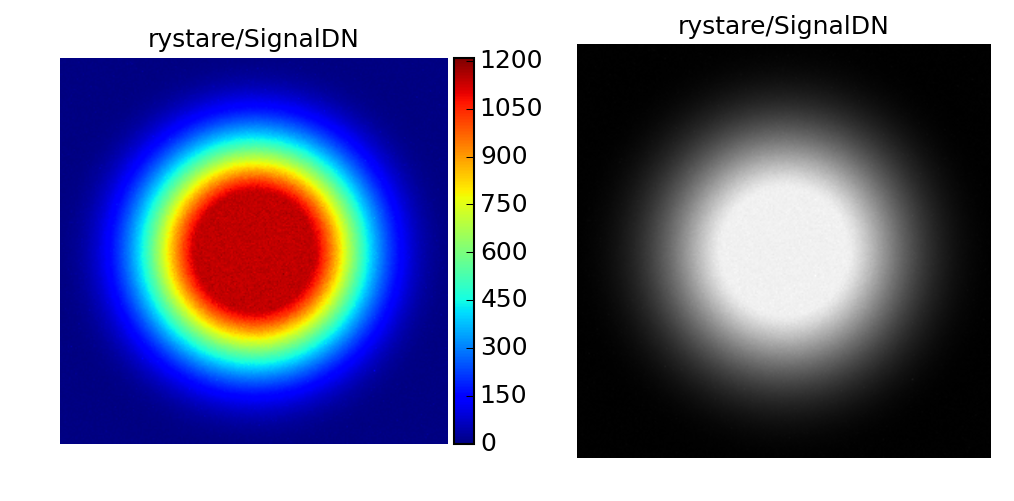

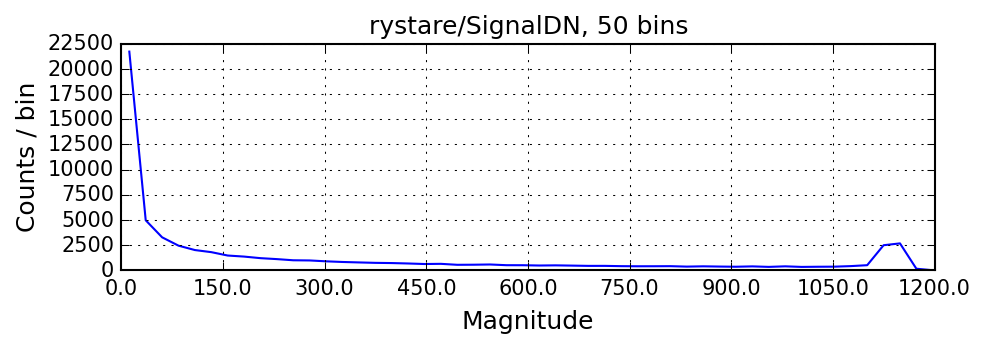

In [20]:
plotResults(imghd5, hdffilename, 'rystare/SignalDN', bins=50) 

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [21]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.0.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
pyradi 0.1.58
Sun Jun 21 15:27:06 2015 South Africa Standard Time